In [110]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import json
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Expected file structure
"""
├── airport
│   ├── airport_CapeTown_aerial.png
│   ├── airport_CapeTown.png
│   ├── airport_short.mp4
│   ├── airport_short.txt
│   ├── cams_info.mat
│   ├── images
│   │   ├── img_0001.jpg
            ...
│   │   └── img_0359.jpg
│   ├── kp_gmaps.mat
│   └── yolo
│       ├── yolo_0001.mat
            ...
│       └── yolo_0359.mat
├── airport.ipynb
"""

In [ ]:

data_path = Path(os.getcwd()) / 'airport'

aerial_fpath = (data_path / './airport_CapeTown_aerial.png')
first_frame_fpath = (data_path / './airport_CapeTown.png')

yolo_fpaths = sorted((data_path / 'yolo').glob('*.mat'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

img_fpaths = sorted((data_path / 'images').glob('*.jpg'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

with open('yolo_classes.json', 'r') as file:
    yolo_classes = json.load(file)['class']


In [52]:
# Assert same number of images and yolo files
assert len(img_fpaths) == len(yolo_fpaths)

# Assert ordered images and yolo files
for i in range(len(img_fpaths)):
    assert img_fpaths[i].stem.split('_')[1] == yolo_fpaths[i].stem.split('_')[1]

# 1. Visualizing available data

In [53]:
file_path = Path('kp_gmaps.mat')
data = sp.io.loadmat(data_path/file_path)['kp_gmaps']
match_video = data[:,:2]
match_maps = data[:,2:]

print("Shape of match_video:", match_video.shape)
print("Shape of match_maps:", match_maps.shape)

Shape of match_video: (8, 2)
Shape of match_maps: (8, 2)


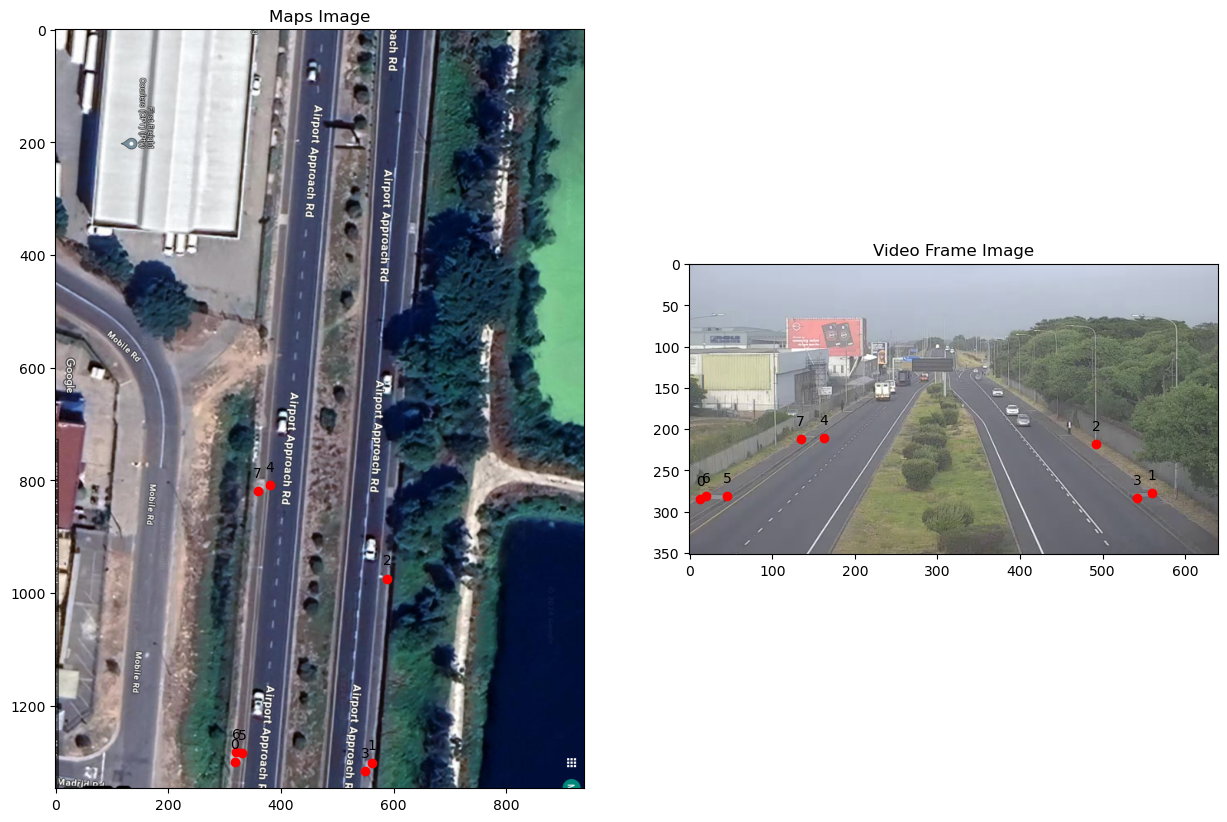

In [ ]:
from utils import plot_image_with_points

aerial_img = Image.open(aerial_fpath)
first_frame_img = Image.open(first_frame_fpath)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    
plot_image_with_points(axes[0], np.array(aerial_img), match_maps, 'Maps Image')
plot_image_with_points(axes[1], np.array(first_frame_img), match_video, 'Video Frame Image')
plt.show()

In [68]:
yolo_data = sp.io.loadmat(yolo_fpaths[0])
frame_0001_img = Image.open(img_fpaths[0])

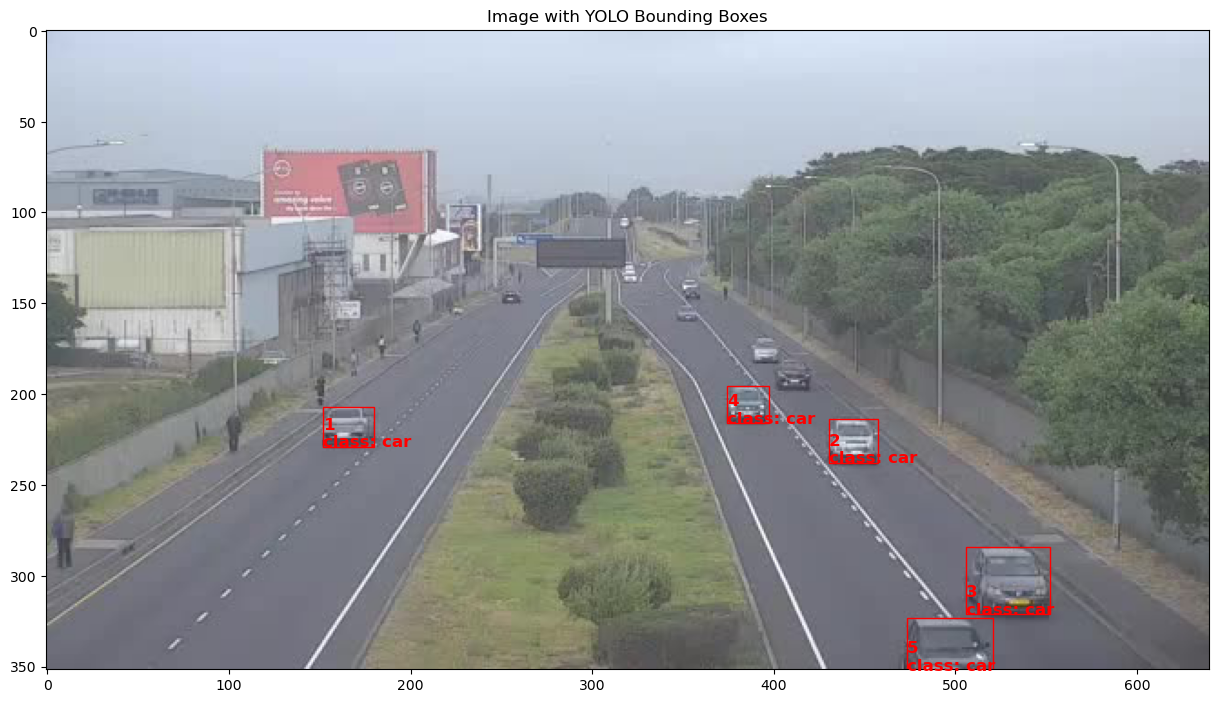

In [109]:
from utils import plot_img_with_yolo

fig, ax = plt.subplots(figsize=(15, 10))
plot_img_with_yolo(ax, np.array(frame_0001_img), yolo_data, yolo_classes)
plt.show()

# 2. Compute homography